We will be using `fastai2` which is still under active development. I am using pip editable install as explained in the [fastai2 repository](https://github.com/fastai/fastai2). This gives me a little bit more of control and also allows me to to navigate through the code. 

Alternatively, you can install `fastai2` directly from github: `pip install git+https://github.com/fastai/fastai2`

When working on this notebook, I was at the following version (hash in git commits) of the library: `85932dec2c0b863f597ded9345c8b93c53efd90d`

In [1]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from pathlib import Path
import pandas as pd
import numpy as np
import librosa

The first order of business will be to read in our data.

In [2]:
trn_df = pd.read_csv('data/train.csv')
trn_paths = list(Path('data/audio_train/').iterdir())

In [3]:
trn_paths[:4]

[PosixPath('data/audio_train/5fca79da.wav'),
 PosixPath('data/audio_train/5f3f655e.wav'),
 PosixPath('data/audio_train/8c0e42bb.wav'),
 PosixPath('data/audio_train/a9bd898d.wav')]

Our first model will be a simple CNN on first two seconds of audio downsampled to 16 khz.

Let's load the data with the medium-level `DataSource` API. Let's first define how the sounds should be read in and later we will look at constructing the labels.

We could resample the audio files on the fly, but that is quite an expensive operation. It's better to incur this cost ones before training and save the results vs having to pay the price during every epoch.

In [4]:
path = trn_paths[0]

In [5]:
%time librosa.core.load(path, sr=16000)

CPU times: user 787 ms, sys: 22.5 ms, total: 809 ms
Wall time: 855 ms


(array([-4.5412817e-06, -4.5701829e-05, -1.4590675e-05, ...,
        -1.3681429e-05, -4.5426914e-05, -5.1247978e-05], dtype=float32), 16000)

In [6]:
%time librosa.core.load(path, sr=None)

CPU times: user 1.99 ms, sys: 1e+03 ns, total: 1.99 ms
Wall time: 1.47 ms


(array([ 0.0000000e+00, -3.0517578e-05, -3.0517578e-05, ...,
        -3.0517578e-05, -6.1035156e-05, -3.0517578e-05], dtype=float32), 44100)

Reading a file without resampling is much, much quicker.

Let's resample the files beforehand and save them to disk.

In [7]:
!rm -rf data/audio_train_22k
!rm -rf data/audio_test_22k

In [8]:
!mkdir data/audio_train_22k
!mkdir data/audio_test_22k

In the multiple runs I carried out, setting `norm=True` performed better for preprocessing of the data. 

I do not know how it works. I am also not sure if this is not something specific to the simple model that we are using below or whether it makes the data in general easier to train on. Given my doubts and as I don't want to accidentally remove useful information, I will set `norm=False`.

Initially, I resampled the data to 16 khz. But since we are not only focusing on human speech, might be this is removing information that might be useful. Due to [the nyquist frequency] being 8khz with 16 khz sampling rate, that would leave anything above 8khz out. Going with 22050 sounds like a safer bet (and is the frequency many people recommend on the forums).

In [9]:
def resample(path, target_sr, output_dir):
    x, sr = librosa.core.load(path, sr=target_sr)
    librosa.output.write_wav(f'{output_dir}/{path.name}', x, sr, norm=False)
    
def resample_train(path): resample(path, 22050, 'data/audio_train_22k/')
def resample_test(path): resample(path, 22050, 'data/audio_test_22k/')

In [10]:
%time parallel(resample_train, trn_paths)

CPU times: user 4.57 s, sys: 655 ms, total: 5.22 s
Wall time: 3min 30s


(#9473) [None,None,None,None,None,None,None,None,None,None...]

There are 3 files in the test set that are corrupt - let's remove them before proceeding.

In [11]:
tst_paths = list(Path('data/audio_test/').iterdir())

In [12]:
%time parallel(resample_test, tst_paths)

CPU times: user 4.34 s, sys: 650 ms, total: 4.99 s
Wall time: 2min 51s


(#9400) [None,None,None,None,None,None,None,None,None,None...]

### Loading the data with DataSource

Let's calculate the mean and starndard deviation of our train set so that we can normalize the data.

In [3]:
def open_audio_file(path):
    x, sr = librosa.core.load(path, sr=None)
    # grabbing first 2 seconds of audio and padding with 0s if too short
    return np.pad(x, (0, 22050*2), 'constant')[:22050*2].reshape(1, -1)

In [4]:
trn_paths = list(Path('data/audio_train_22k/').iterdir())
tst_paths = list(Path('data/audio_test_22k/').iterdir())

In [5]:
means = []
std_devs = []
for path in trn_paths:
    audio = open_audio_file(path)
    means.append(audio.mean())
    std_devs.append(audio.std())

In [6]:
np.mean(means), np.mean(std_devs)

(5.1284875e-05, 0.07702511)

The mean is very close to 0, so we don't need to worry about it. The standard deviation is 0.08, which is probably not what we want. Let's try bringing it closer to 1.

One thing we could do is we could divide the array by 0.08 directly before returning it from `open_audio_file`.

This would be the easiest approach and it would work. But as the purpose of this notebook is to explore the functionatliy of `fastai v2`, let's take a look at two other ways we could go about this.

First of all, we could register our version of `encodes` with the `TypeDispatch` mechanism of `ToTensor`, one to be used with `np.ndarray`. In the `encodes` method we could do the normalization like so: 

In [7]:
mean_std = 0.077

In [8]:
@ToTensor
def encodes(self, o:np.ndarray): return TensorBase(o) / mean_std

item_audio_tfms = [ToTensor()]

This would work. But there is also another way of going about this that can give us even further insights into how `fastai v2` works.

In [9]:
class TensorAudio(TensorBase): pass

In [10]:
ary = open_audio_file(trn_paths[1]) # reading in one of the files for demonstration purposes

In [11]:
# again, we define our version of `encodes`
# this time to return our custom Type

@ToTensor
def encodes(self, o:np.ndarray): return TensorAudio(o) 

In [12]:
type(ToTensor()(ary))

__main__.TensorAudio

It worked! We can now register our type with the dispatch mechanism of `Normalize`!

In [13]:
@Normalize
def encodes(self, o:TensorAudio): return o / self.std

In [14]:
ToTensor()(ary)

tensor([[0.1239, 0.1608, 0.3262,  ..., 0.0000, 0.0000, 0.0000]])

In [15]:
Normalize(std=mean_std)(ToTensor()(ary))

tensor([[1.6093, 2.0883, 4.2360,  ..., 0.0000, 0.0000, 0.0000]])

This functionality might be slightly intimidating at first, but do not worry! It is intended for intermediate users and might take a little while to get used to, even though the abstraction is very clear and easy to understand once you spend some time experimenting with it.

Give it a bit of time and you'll find that you will be breezing through the `DataSource` API sooner than you expect!

In [16]:
trn_df_idx = trn_df.set_index('fname') 

# defining a way how to go from a path to a class label
def item_to_label(path): return trn_df_idx.loc[path.name].label

In [17]:
# transforms that will be called initially on `path` to read in the audio file and the category label
tfms = [[open_audio_file], [item_to_label, Categorize()]]

# transforms called on the item returned by the transforms above
item_audio_tfms = [ToTensor()]

Randomly assigning 20% of data to the validation set.

In [18]:
split_idxs = RandomSplitter()(trn_paths)
dsrc = DataSource(trn_paths, tfms, splits=split_idxs)

In [19]:
# last but not least - we move our entire batch to the GPU and Normalize
batch_tfms = [Cuda(), Normalize(std=mean_std)]

# our databunch gets constructed right here
# up until this point, using `DataSource`, defined how to go from `trn_paths` to reading in individual items
# here we define how to go from items to batches
dbch = dsrc.databunch(after_item=item_audio_tfms, after_batch=batch_tfms, bs=128, num_workers=12)

Let's verify that we indeed were able to normalize the data

In [20]:
means, std_devs = [], []

for batch in dbch.train_dl:
    means.append(batch[0].mean().cpu().item())
    std_devs.append(batch[0].std().mean().cpu().item())

In [21]:
np.mean(means), np.mean(std_devs)

(0.00031681953580612, 0.9519697670209206)

Looks good to me!

### Building the model

Let's initially use the Conv1d architecture from this [tutorial](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data)

In [22]:
def conv_block(in_channels, out_channels, kernel_size):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size),
        nn.ReLU(),
        nn.BatchNorm1d(out_channels),
        nn.Conv1d(out_channels, out_channels, kernel_size),
        nn.ReLU(),
        nn.BatchNorm1d(out_channels),
    )

In [23]:
def pool_and_dropout_block(pool_size):
    return nn.Sequential(
        nn.MaxPool1d(pool_size),
        nn.Dropout(0.1)
    )

In [24]:
def fc_block(in_features, out_features):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.ReLU(),
        nn.BatchNorm1d(out_features),
    )

In [25]:
arch = nn.Sequential(
    conv_block(1, 16, 9),
    pool_and_dropout_block(16),
    conv_block(16, 32, 3),
    pool_and_dropout_block(4),
    conv_block(32, 64, 3),
    pool_and_dropout_block(4),
    conv_block(64, 128, 3),
    nn.AdaptiveAvgPool1d(1),
    Flatten(),
    fc_block(128, 128),
    fc_block(128, 128),
    nn.Linear(128, dbch.c)
)

In [26]:
def top_3_accuracy(preds, targs): return top_k_accuracy(preds, targs, 3)

In [27]:
learn = Learner(
    dbch, arch, metrics=[accuracy, top_3_accuracy],
    opt_func=partial(Adam, wd=0.01, eps=1e-3)
)

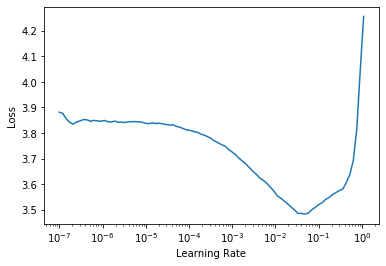

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.256835,3.580065,0.123020,0.270327,00:10
1,2.763949,2.941054,0.232841,0.470433,00:10
2,2.441679,3.013535,0.282471,0.469905,00:10
3,2.232242,3.342233,0.201162,0.401795,00:10
4,2.024225,2.737794,0.336853,0.522703,00:10
5,1.849048,4.260725,0.221225,0.438754,00:10
6,1.692925,2.319106,0.407603,0.643083,00:10
7,1.556222,2.323946,0.423442,0.635692,00:10
8,1.432245,1.992917,0.475713,0.689018,00:10
9,1.349726,1.955788,0.492080,0.705913,00:10


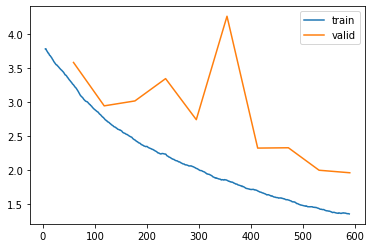

In [30]:
learn.recorder.plot_loss()

In [31]:
learn.save('first_model')

Let's grab the predictions on the test set

In [32]:
preds = learn.get_preds(dl=test_dl(dbch, tst_paths))[0]

In [33]:
predicted_label_idxs = preds.argsort(descending=True)[:, :3]

In [34]:
fns, predicted_labels = [], []

for path, idxs in zip(tst_paths, predicted_label_idxs):
    fns.append(path.name)
    predicted_labels.append([dbch.vocab[idx] for idx in idxs])

In [35]:
sub = pd.DataFrame({'fname': fns, 'label': predicted_labels})
sub.label = sub.label.apply(lambda lst: ' '.join(lst))

In [36]:
sub.head()

,fname,label
0,d2217d56.wav,Bass_drum Finger_snapping Tambourine
1,614a7c76.wav,Flute Clarinet Cello
2,02198549.wav,Scissors Keys_jangling Hi-hat
3,e6eb9ec4.wav,Saxophone Clarinet Flute
4,0da592f2.wav,Clarinet Flute Glockenspiel


In [37]:
mkdir -p data/submissions

In [38]:
sub_name = 'first_model'
sub.to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)

In [39]:
!kaggle competitions submit -c freesound-audio-tagging -f data/submissions/{sub_name}.csv.zip -m {sub_name}

100%|██████████████████████████████████████| 87.6k/87.6k [00:03<00:00, 23.8kB/s]
Successfully submitted to Freesound General-Purpose Audio Tagging Challenge